# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
print('brain name: {}'.format(brain_name))
print()
print('action space      - size: {:2d} \t(type: {})'.format(brain.vector_action_space_size, brain.vector_action_space_type))
print('observation space - size: {:2d} \t(type: {})'.format(brain.vector_observation_space_size, brain.vector_observation_space_type))

brain name: BananaBrain

action space      - size:  4 	(type: discrete)
observation space - size: 37 	(type: continuous)


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Dueling Double-DQN

The implementation is based on [Wang et al](https://arxiv.org/abs/1511.06581)'s work.

In [18]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch

from collections import deque
from datetime import datetime

import numpy as np


from agents.dueling_ddqn_agent import Dueling_DDQN_Agent
from task import Task

n_episodes=2000

### model file
model_name='dueling_ddqn'

# logging
dir_logs='./logs/'
filename_log='scores_{}.pickles'.format(model_name)
path_log = dir_logs + filename_log

dir_models='./models/'
filename_model='checkpoint_{}.pth'.format(model_name)
path_model = dir_models + filename_model

if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)
    
if not os.path.exists(dir_models):
    os.makedirs(dir_models)
    
LENGTH_MOVING_AVERAGE=100

def dueling_ddqn(unity_env, path_model, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, seed=0, length_moving_average=LENGTH_MOVING_AVERAGE, n_printing_period=100):

    task = Task(unity_env=unity_env)
    agent = Dueling_DDQN_Agent(task.state_size, task.action_size, seed=seed, is_clip=False)
    

    scores = []
    scores_window = deque(maxlen=length_moving_average)
    eps = eps_start
    
    time_start = datetime.now()
    
    for i_episode in range(1, n_episodes+1):
        state = task.reset()
        score = 0.0

        for _ in range(max_t):
            
            # apply epsilon-greedy algorithm
            action = agent.act(state, eps)

            next_state, reward, done, info = task.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state

            score += reward

            if done:
                break

        scores_window.append(score)
        scores.append(score)

        eps = max(eps_end, eps_decay * eps)
        
        # print training message without newline
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        # print training message
        if i_episode % n_printing_period == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, execution time={}'.format(i_episode, 
                                                                                np.mean(scores_window), 
                                                                                datetime.now() - time_start))
            time_start = datetime.now()
        
        # ending criterion
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-length_moving_average, np.mean(scores_window)))
            break
            
            

                  
    # save model
    torch.save(agent.qnetwork_local.state_dict(), path_model)

    return scores


scores = dueling_ddqn(unity_env=env, path_model=path_model, n_episodes=n_episodes)

with open(path_log, 'wb') as f:
    pickle.dump(scores, f)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode 100	Average Score: 0.62, execution time=0:01:39.731444
Episode 200	Average Score: 3.42, execution time=0:01:40.281683
Episode 300	Average Score: 7.10, execution time=0:01:41.126893
Episode 400	Average Score: 10.90, execution time=0:01:43.151091
Episode 480	 Average Score: 13.04
Environment solved in 380 episodes!	Average Score: 13.04


### Eps decay=0.98, Eps end=0.1

In [7]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch

from collections import deque
from datetime import datetime

import numpy as np


from agents.dueling_ddqn_agent import Dueling_DDQN_Agent
from task import Task

n_episodes=2000

### model file
model_name='dueling_ddqn_epsDecay_098_epsEnd_01'

# logging
dir_logs='./logs/'
filename_log='scores_{}.pickles'.format(model_name)
path_log = dir_logs + filename_log

dir_models='./models/'
filename_model='checkpoint_{}.pth'.format(model_name)
path_model = dir_models + filename_model

if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)
    
if not os.path.exists(dir_models):
    os.makedirs(dir_models)
    
LENGTH_MOVING_AVERAGE=100

def dueling_ddqn(unity_env, path_model, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, seed=0, length_moving_average=LENGTH_MOVING_AVERAGE, n_printing_period=100):

    task = Task(unity_env=unity_env)
    agent = Dueling_DDQN_Agent(task.state_size, task.action_size, seed=seed, is_clip=False, clip=10.0)
    

    scores = []
    scores_window = deque(maxlen=length_moving_average)
    eps = eps_start
    
    time_start = datetime.now()
    
    for i_episode in range(1, n_episodes+1):
        state = task.reset()
        score = 0.0

        for _ in range(max_t):
            
            # apply epsilon-greedy algorithm
            action = agent.act(state, eps)

            next_state, reward, done, info = task.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state

            score += reward

            if done:
                break

        scores_window.append(score)
        scores.append(score)

        eps = max(eps_end, eps_decay * eps)
        
        # print training message without newline
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        # print training message
        if i_episode % n_printing_period == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, execution time={}'.format(i_episode, 
                                                                                np.mean(scores_window), 
                                                                                datetime.now() - time_start))
            time_start = datetime.now()
        
        # ending criterion
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-length_moving_average, np.mean(scores_window)))
            break
            
            

                  
    # save model
    torch.save(agent.qnetwork_local.state_dict(), path_model)

    return scores


scores = dueling_ddqn(unity_env=env, path_model=path_model, n_episodes=n_episodes,
                     eps_decay=0.98, eps_end=0.1)

with open(path_log, 'wb') as f:
    pickle.dump(scores, f)


Episode 100	Average Score: 2.46, execution time=0:01:41.023919
Episode 200	Average Score: 7.04, execution time=0:01:39.939979
Episode 300	Average Score: 10.72, execution time=0:01:39.859323
Episode 400	Average Score: 11.97, execution time=0:01:41.214624
Episode 442	 Average Score: 13.00
Environment solved in 342 episodes!	Average Score: 13.00


### Eps decay=0.98, Eps end=0.1

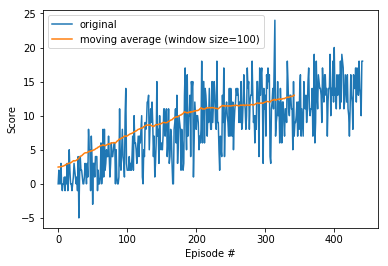

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
    
def plot_result(path_log, n_moving_window):
    with open(path_log, 'rb') as f:
        scores = pickle.load(f)
        
    moving_average = np.convolve(scores, np.ones((n_moving_window,))/n_moving_window, mode='valid')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='original')
    plt.plot(np.arange(len(moving_average)), moving_average, label='moving average (window size={})'.format(n_moving_window))
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    

n_moving_window = 100
plot_result(path_log, n_moving_window)

In [5]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch

from collections import deque
from datetime import datetime

import numpy as np


from agents.dueling_ddqn_agent import Dueling_DDQN_Agent
from task import Task

n_episodes=2000

### model file
model_name='dueling_ddqn_epsDecay_098_epsEnd_01'

# logging
dir_logs='./logs/'
filename_log='scores_{}.pickles'.format(model_name)
path_log = dir_logs + filename_log

dir_models='./models/'
filename_model='checkpoint_{}.pth'.format(model_name)
path_model = dir_models + filename_model

if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)
    
if not os.path.exists(dir_models):
    os.makedirs(dir_models)
    
LENGTH_MOVING_AVERAGE=100

def dueling_ddqn(unity_env, path_model, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, seed=0, length_moving_average=LENGTH_MOVING_AVERAGE, n_printing_period=100):

    task = Task(unity_env=unity_env)
    agent = Dueling_DDQN_Agent(task.state_size, task.action_size, seed=seed, is_clip=False, clip=10.0)
    

    scores = []
    scores_window = deque(maxlen=length_moving_average)
    eps = eps_start
    
    time_start = datetime.now()
    cnt_steps = 0
    
    for i_episode in range(1, n_episodes+1):
        state = task.reset()
        score = 0.0

        for _ in range(max_t):
            cnt_steps += 1
            
            # apply epsilon-greedy algorithm
            action = agent.act(state, eps)

            next_state, reward, done, info = task.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state

            score += reward

            if done:
                break

        scores_window.append(score)
        scores.append(score)

        eps = max(eps_end, eps_decay * eps)
        
        # print training message without newline
        print('\rEpisode {}\t Average Score: {:.2f}\tAccumulated steps:{}'.format(i_episode, 
                                                                                  np.mean(scores_window),
                                                                                 cnt_steps), end="")

        # print training message
        if i_episode % n_printing_period == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, execution time={}'.format(i_episode, 
                                                                                np.mean(scores_window), 
                                                                                datetime.now() - time_start))
            time_start = datetime.now()
        
        # ending criterion
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-length_moving_average, np.mean(scores_window)))
            break
            
            

    print('total steps={}'.format(cnt_steps)) 
    
    # save model
    torch.save(agent.qnetwork_local.state_dict(), path_model)

    return scores


scores = dueling_ddqn(unity_env=env, path_model=path_model, n_episodes=n_episodes,
                     eps_decay=0.98, eps_end=0.1)

with open(path_log, 'wb') as f:
    pickle.dump(scores, f)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode 100	Average Score: 0.53, execution time=0:01:53.825174
Episode 200	Average Score: 3.90, execution time=0:01:55.571172
Episode 300	Average Score: 7.60, execution time=0:01:55.952221
Episode 400	Average Score: 10.78, execution time=0:01:58.031732
Episode 500	Average Score: 12.10, execution time=0:01:59.545478
Episode 600	Average Score: 12.78, execution time=0:01:58.383572
Episode 616	 Average Score: 13.05	Accumulated steps:184800
Environment solved in 516 episodes!	Average Score: 13.05
total steps=184800


### Eps decay=0.98, Eps end=0.1, Clip=10.0

In [10]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch

from collections import deque
from datetime import datetime

import numpy as np


from agents.dueling_ddqn_agent import Dueling_DDQN_Agent
from task import Task

n_episodes=2000

### model file
model_name='dueling_ddqn_epsDecay_098_epsEnd_01_Clip_10'

# logging
dir_logs='./logs/'
filename_log='scores_{}.pickles'.format(model_name)
path_log = dir_logs + filename_log

dir_models='./models/'
filename_model='checkpoint_{}.pth'.format(model_name)
path_model = dir_models + filename_model

if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)
    
if not os.path.exists(dir_models):
    os.makedirs(dir_models)
    
LENGTH_MOVING_AVERAGE=100

def dueling_ddqn(unity_env, path_model, is_clip=False, clip=10.0, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, seed=0, length_moving_average=LENGTH_MOVING_AVERAGE, n_printing_period=100):

    task = Task(unity_env=unity_env)
    agent = Dueling_DDQN_Agent(task.state_size, task.action_size, seed=seed, is_clip=is_clip, clip=clip)
    

    scores = []
    scores_window = deque(maxlen=length_moving_average)
    eps = eps_start
    
    time_start = datetime.now()
    
    for i_episode in range(1, n_episodes+1):
        state = task.reset()
        score = 0.0

        for _ in range(max_t):
            
            # apply epsilon-greedy algorithm
            action = agent.act(state, eps)

            next_state, reward, done, info = task.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state

            score += reward

            if done:
                break

        scores_window.append(score)
        scores.append(score)

        eps = max(eps_end, eps_decay * eps)
        
        # print training message without newline
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        # print training message
        if i_episode % n_printing_period == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, execution time={}'.format(i_episode, 
                                                                                np.mean(scores_window), 
                                                                                datetime.now() - time_start))
            time_start = datetime.now()
        
        # ending criterion
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-length_moving_average, np.mean(scores_window)))
            break
            
            

                  
    # save model
    torch.save(agent.qnetwork_local.state_dict(), path_model)

    return scores


scores = dueling_ddqn(unity_env=env, path_model=path_model, n_episodes=n_episodes,
                     eps_decay=0.98, eps_end=0.1, is_clip=True, clip=10.0)

with open(path_log, 'wb') as f:
    pickle.dump(scores, f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Episode 100	Average Score: 0.25, execution time=0:01:39.132597
Episode 200	Average Score: 3.58, execution time=0:01:41.867505
Episode 300	Average Score: 6.42, execution time=0:01:45.943246
Episode 400	Average Score: 11.29, execution time=0:01:46.175104
Episode 477	 Average Score: 13.00
Environment solved in 377 episodes!	Average Score: 13.00


### Eps decay=0.98, Eps end=0.1, Clip=10.0

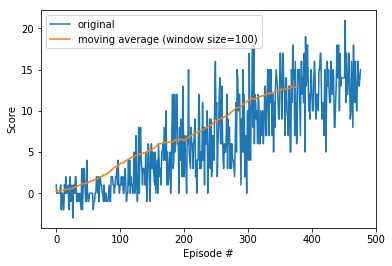

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
    
def plot_result(path_log, n_moving_window):
    with open(path_log, 'rb') as f:
        scores = pickle.load(f)
        
    moving_average = np.convolve(scores, np.ones((n_moving_window,))/n_moving_window, mode='valid')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='original')
    plt.plot(np.arange(len(moving_average)), moving_average, label='moving average (window size={})'.format(n_moving_window))
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    

n_moving_window = 100
plot_result(path_log, n_moving_window)

### Eps decay=0.98, Eps end=0.1, Clip=20.0

In [3]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch

from collections import deque
from datetime import datetime

import numpy as np


from agents.dueling_ddqn_agent import Dueling_DDQN_Agent
from task import Task

n_episodes=2000

### model file
model_name='dueling_ddqn_epsDecay_098_epsEnd_01_Clip_20'

# logging
dir_logs='./logs/'
filename_log='scores_{}.pickles'.format(model_name)
path_log = dir_logs + filename_log

dir_models='./models/'
filename_model='checkpoint_{}.pth'.format(model_name)
path_model = dir_models + filename_model

if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)
    
if not os.path.exists(dir_models):
    os.makedirs(dir_models)
    
LENGTH_MOVING_AVERAGE=100

def dueling_ddqn(unity_env, path_model, is_clip=False, clip=10.0, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, seed=0, length_moving_average=LENGTH_MOVING_AVERAGE, n_printing_period=100):

    task = Task(unity_env=unity_env)
    agent = Dueling_DDQN_Agent(task.state_size, task.action_size, seed=seed, is_clip=is_clip, clip=clip)
    

    scores = []
    scores_window = deque(maxlen=length_moving_average)
    eps = eps_start
    
    time_start = datetime.now()
    
    for i_episode in range(1, n_episodes+1):
        state = task.reset()
        score = 0.0

        for _ in range(max_t):
            
            # apply epsilon-greedy algorithm
            action = agent.act(state, eps)

            next_state, reward, done, info = task.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state

            score += reward

            if done:
                break

        scores_window.append(score)
        scores.append(score)

        eps = max(eps_end, eps_decay * eps)
        
        # print training message without newline
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        # print training message
        if i_episode % n_printing_period == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, execution time={}'.format(i_episode, 
                                                                                np.mean(scores_window), 
                                                                                datetime.now() - time_start))
            time_start = datetime.now()
        
        # ending criterion
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-length_moving_average, np.mean(scores_window)))
            break
            
            

                  
    # save model
    torch.save(agent.qnetwork_local.state_dict(), path_model)

    return scores


scores = dueling_ddqn(unity_env=env, path_model=path_model, n_episodes=n_episodes,
                     eps_decay=0.98, eps_end=0.1, is_clip=True, clip=20.0)

with open(path_log, 'wb') as f:
    pickle.dump(scores, f)

Episode 100	Average Score: 0.46, execution time=0:01:41.376187
Episode 200	Average Score: 3.25, execution time=0:01:38.063651
Episode 300	Average Score: 7.45, execution time=0:01:40.381402
Episode 400	Average Score: 11.10, execution time=0:01:42.959677
Episode 500	Average Score: 12.95, execution time=0:01:41.835743
Episode 513	 Average Score: 13.12
Environment solved in 413 episodes!	Average Score: 13.12


### Eps decay=0.98, Eps end=0.1, Clip=20.0

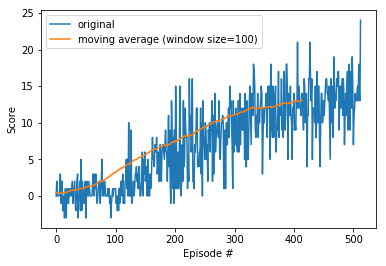

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
    
def plot_result(path_log, n_moving_window):
    with open(path_log, 'rb') as f:
        scores = pickle.load(f)
        
    moving_average = np.convolve(scores, np.ones((n_moving_window,))/n_moving_window, mode='valid')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='original')
    plt.plot(np.arange(len(moving_average)), moving_average, label='moving average (window size={})'.format(n_moving_window))
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    

n_moving_window = 100
plot_result(path_log, n_moving_window)

#### Free run - Eps decay=0.98, Eps end=0.1

In [3]:
%load_ext autoreload
%autoreload 2

import pickle
import os
import torch

from collections import deque
from datetime import datetime

import numpy as np


from agents.dueling_ddqn_agent import Dueling_DDQN_Agent
from task import Task

n_episodes=2000

### model file
model_name='dueling_ddqn_free_run_epsDecay_098_epsEnd_01'

# logging
dir_logs='./logs/'
filename_log='scores_{}.pickles'.format(model_name)
path_log = dir_logs + filename_log

dir_models='./models/'
filename_model='checkpoint_{}.pth'.format(model_name)
path_model = dir_models + filename_model

if not os.path.exists(dir_logs):
    os.makedirs(dir_logs)
    
if not os.path.exists(dir_models):
    os.makedirs(dir_models)
    
LENGTH_MOVING_AVERAGE=100



def dueling_ddqn(unity_env, path_model, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, seed=0, length_moving_average=LENGTH_MOVING_AVERAGE, n_printing_period=100):

    task = Task(unity_env=unity_env)
    agent = Dueling_DDQN_Agent(task.state_size, task.action_size, seed=seed, is_clip=False, clip=10.0)
    

    scores = []
    scores_window = deque(maxlen=length_moving_average)
    eps = eps_start
    
    time_start = datetime.now()
    
    is_print=False
    
    for i_episode in range(1, n_episodes+1):
        state = task.reset()
        score = 0.0

        for _ in range(max_t):
            
            # apply epsilon-greedy algorithm
            action = agent.act(state, eps)

            next_state, reward, done, info = task.step(action)

            agent.step(state, action, reward, next_state, done)

            state = next_state

            score += reward

            if done:
                break

        scores_window.append(score)
        scores.append(score)

        eps = max(eps_end, eps_decay * eps)
        
        # print training message without newline
        print('\rEpisode {}\t Average Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        # print training message
        if i_episode % n_printing_period == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}, execution time={}'.format(i_episode, 
                                                                                np.mean(scores_window), 
                                                                                datetime.now() - time_start))
            time_start = datetime.now()
        
        # ending criterion
        if np.mean(scores_window) >= 13.0 and is_print == False:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-length_moving_average, np.mean(scores_window)))
            is_print = True
#             break
            
            

                  
    # save model
    torch.save(agent.qnetwork_local.state_dict(), path_model)

    return scores


scores = dueling_ddqn(unity_env=env, path_model=path_model, n_episodes=n_episodes,
                     eps_decay=0.98, eps_end=0.1)

with open(path_log, 'wb') as f:
    pickle.dump(scores, f)


Episode 100	Average Score: 1.61, execution time=0:01:45.644826
Episode 200	Average Score: 7.08, execution time=0:01:42.823174
Episode 300	Average Score: 10.20, execution time=0:01:45.172715
Episode 400	Average Score: 12.33, execution time=0:01:47.984022
Episode 433	 Average Score: 13.02
Environment solved in 333 episodes!	Average Score: 13.02
Episode 500	Average Score: 13.45, execution time=0:01:47.611744
Episode 600	Average Score: 13.34, execution time=0:01:45.891318
Episode 700	Average Score: 14.22, execution time=0:01:47.420275
Episode 800	Average Score: 14.22, execution time=0:01:47.185262
Episode 900	Average Score: 13.78, execution time=0:01:47.266561
Episode 1000	Average Score: 13.89, execution time=0:01:49.725023
Episode 1100	Average Score: 14.17, execution time=0:01:47.762841
Episode 1200	Average Score: 13.91, execution time=0:01:47.285504
Episode 1300	Average Score: 14.13, execution time=0:01:50.110815
Episode 1400	Average Score: 13.71, execution time=0:01:47.183822
Episode 15

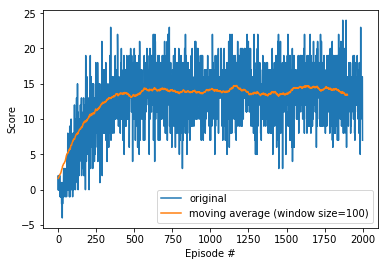

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
    
def plot_result(path_log, n_moving_window):
    with open(path_log, 'rb') as f:
        scores = pickle.load(f)
        
    moving_average = np.convolve(scores, np.ones((n_moving_window,))/n_moving_window, mode='valid')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label='original')
    plt.plot(np.arange(len(moving_average)), moving_average, label='moving average (window size={})'.format(n_moving_window))
    plt.legend()
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    

n_moving_window = 100
plot_result(path_log, n_moving_window)